In [17]:
from collections import Counter
import copy
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import numpy as np
import pandas as pd
from tqdm import tqdm
import utils
import sampling

In [42]:
class FederatedModel:
    def __init__(
        self,
        device,
        num_devices=110,
        num_trusted_devices=None,
        use_trusted=False,
        num_malicious_devices=0,
        network='lenet',
        global_rounds=3,
        local_epochs=5,
        batch_size=64,
        learning_rate=0.001,
        optim='adam',
        dataset='mnist',
        split_type='iid',
        malicious_device_args={},
    ):
        self.network = network
        self.dataset = dataset
        self.num_devices = num_devices
        self.global_rounds = global_rounds
        self.batch_size = batch_size
        self.local_epochs = local_epochs
        self.learning_rate = learning_rate
        self.optim = optim
        self.device = device
        self.num_trusted_devices = num_trusted_devices
        self.use_trusted = use_trusted
        self.num_malicious_devices = num_malicious_devices
        self.malicious_device_args = malicious_device_args

        self.global_network = utils.get_network(network, dataset).to(device)
        self.train_dataset, self.test_dataset = utils.get_dataset(dataset)


        self.train_dataset_idxs = sampling.split_dataset(
            self.train_dataset, num_devices, split_type
        )

        while any(len(x) == 0 for x in self.train_dataset_idxs):
            self.train_dataset_idxs = sampling.split_dataset(
                self.train_dataset, num_devices, split_type
            )

        np.random.shuffle(self.train_dataset_idxs) # Needed?

        self.train_dataset_classes = [Counter([self.train_dataset[idx][1] for idx in idxs]) for idxs in self.train_dataset_idxs]
        print("Len of train_dataset_classes: ",len(self.train_dataset_classes))
        print("train_dataset_classes: ",self.train_dataset_classes[0])
        
        if self.num_trusted_devices is None and self.use_trusted:
            self.num_trusted_devices = 1
            self.trusted_devices = {0}
            self.trusted_devices_classes = self.train_dataset_classes[0]
            
            print("Keys of trusted_devices_classes:",self.trusted_devices_classes.keys())

            while len(self.trusted_devices_classes.keys()) < 10: # TODO: Don't hardcode classes
                x = random.choice(list(set(range(len(self.train_dataset_idxs))) - self.trusted_devices))
                print("Length of trusted device: ",len(trusted_devices))
                if len(set(self.train_dataset_classes[x].keys()) - set(self.trusted_devices_classes.keys())) > 0:
                    self.trusted_devices |=  {x}
                    self.trusted_devices_classes += self.train_dataset_classes[x]
                    self.num_trusted_devices += 1
        
        self.train_dataset_idxs = (
            [x for i, x in enumerate(self.train_dataset_idxs) if i in self.trusted_devices] +
            [x for i, x in enumerate(self.train_dataset_idxs) if i not in self.trusted_devices]
        )

        print("==============To find the malicious devices=============")
        print("Trusted devices: ", (self.num_trusted_devices))
        print("Malicious devices: ", self.num_malicious_devices)
        print("Range: ", range(self.num_trusted_devices, self.num_malicious_devices))
        
        self.trusted_devices = list(range(self.num_trusted_devices))
        self.malicious_devices = list(range(self.num_trusted_devices, self.num_malicious_devices))
        
        print("malicious_devices:",self.malicious_devices)

        if num_malicious_devices > 0 and malicious_device_args.get('wrong_dataset') == True:
            self.wrong_train_dataset, _ = utils.get_dataset('cifar10' if dataset == 'mnist' else 'mnist')

    def get_loader(self, dataset):
        return DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True)

    def get_local_dataset(self, d, is_malicious):
        if is_malicious:
            if self.malicious_device_args.get('flip') is not None:
                n_flip = self.malicious_device_args.get('flip')
                dataset = torch.utils.data.Subset(self.train_dataset, self.train_dataset_idxs[d])
                return utils.FlippedDataset(dataset, 10, n_flip) # TODO: Change 10
            elif self.malicious_device_args.get('wrong_dataset') == True:
                device_dataset_size = int(len(self.train_dataset) / self.num_devices)
                dataset_idxs = list(range(len(self.wrong_train_dataset)))
                random.shuffle(dataset_idxs)
                return torch.utils.data.Subset(
                    self.wrong_train_dataset, dataset_idxs[:device_dataset_size]
                )

        return torch.utils.data.Subset(self.train_dataset, self.train_dataset_idxs[d])

    def train(self, calculate_global_cosine=False, calculate_local_grad_cosine=False):
        stats = []
        for r in range(self.global_rounds):
            global_weights, _, round_stats = self.train_one_round(r, calculate_global_cosine, calculate_local_grad_cosine)

            self.global_network.load_state_dict(global_weights)
            round_stats['test_accuracy'] = utils.check_accuracy(
                self.get_loader(self.test_dataset),
                self.global_network,
                self.device
            )
            stats.append(round_stats)

        return pd.DataFrame(stats)
    
    def train_one_round(self, r, calculate_global_cosine=False, calculate_local_grad_cosine=False):
        malicious_devices = self.malicious_devices

        local_weights = []
        stats = {}
        
        print("Global_cosine value: ", str(calculate_global_cosine))
        print("Local_grad_cosine: ",str(calculate_local_grad_cosine))

        for d in tqdm(range(self.num_devices)):
            local_weights.append(self.train_device(d, d in malicious_devices, stats))
            if calculate_global_cosine:
                local_network = utils.get_network(self.network, self.dataset).to(self.device)
                local_network.load_state_dict(local_weights[-1])
                stats[f'{d}_cosine'] = utils.model_cosine(self.global_network, local_network)

        
        if calculate_local_grad_cosine:
            for i in range(self.num_trusted_devices):
                for j in range(self.num_devices):
                    x = utils.get_network(self.network, self.dataset).to(self.device)
                    y = utils.get_network(self.network, self.dataset).to(self.device)
                    x.load_state_dict(local_weights[i])
                    y.load_state_dict(local_weights[j])
                    stats[f"{i}_{j}_cosine"] = utils.model_grad_cosine(
                        self.global_network, x, y
                    )
        
        global_weights = utils.model_average(local_weights)

        return global_weights, local_weights, stats

    def train_device(self, d, is_malicious, stats):
        network = copy.deepcopy(self.global_network).to(self.device)

        optim = self.get_optim(network, is_malicious)
        dataset = self.get_local_dataset(d, is_malicious)
        total_loss = 0

        for _, (data, targets) in enumerate(self.get_loader(dataset)):
            data = data.to(device=self.device)
            targets = targets.to(device=self.device)

            loss = F.cross_entropy(network(data), targets)
            total_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()

        return network.state_dict()

    def get_optim(self, model, is_malicious):
        lr = self.learning_rate
        if is_malicious and self.malicious_device_args.get('lr') is not None:
            lr = self.malicious_device_args['lr']

        if self.optim == "sgd":
            return torch.optim.SGD(model.parameters(), lr=lr)
        elif self.optim == "adam":
            return torch.optim.Adam(model.parameters(), lr=lr)
        else:
            raise NotImplementedError("Invalid Optimizer")

In [43]:
def phase0(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase0',
    local_epochs=5, 
    global_rounds=10):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        local_epochs=local_epochs,
        global_rounds=global_rounds
        )

    stats = model.train().astype('float')
    stats.to_excel(f'{f}.xlsx')

    print(f)
    print(stats)


In [44]:
def phase1(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase1',
    local_epochs=5, 
    global_rounds=10):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        local_epochs=local_epochs,
        global_rounds=global_rounds
        )

    stats = model.train(calculate_global_cosine=True).astype('float')
    stats.to_excel(f'{f}.xlsx')

    plt.clf()
    ss = stats[[f'{i}_cosine' for i in range(110)]].astype(float).to_numpy()
    ax = sns.heatmap(ss)
    ax.figure.savefig(f'{f}_heatmap.png')

    print(f)
    print(stats)

In [45]:
def phase2(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase2',
    local_epochs=5, 
    global_rounds=10):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        num_trusted_devices=1,
        use_trusted=True,
        local_epochs=local_epochs,
        global_rounds=global_rounds
    )

    stats = model.train(calculate_local_grad_cosine=True).astype('float')
    stats.to_excel(f'{f}.xlsx')

    plt.clf()
    ss = stats[[f'0_{j}_cosine' for j in range(1, 110)]].astype(float).to_numpy()
    ax = sns.heatmap(ss)
    ax.figure.savefig(f'{f}_heatmap.png')

    print(f)
    print(stats)

In [46]:
def phase3(
    device,
    split_type,
    malicious_type = None,
    num_malicious_devices=0,
    fname='outputs/phase3',
    local_epochs=5, 
    global_rounds=3):

    plt.clf()
    f = None
    if malicious_type is None:
        f = f'{fname}_{split_type}_{num_malicious_devices}'
    else:
        mt = list(malicious_type.keys())[0]
        f = f'{fname}_{split_type}_{mt}_{malicious_type[mt]}_{num_malicious_devices}'

    model = FederatedModel(
        device=device, 
        split_type=split_type,
        malicious_device_args={} if malicious_type is None else malicious_type,
        num_malicious_devices=num_malicious_devices,
        num_trusted_devices=None, # Automatically assign trusted devices
        use_trusted=True,
        local_epochs=local_epochs,
        global_rounds=global_rounds
    )

    stats = model.train(calculate_local_grad_cosine=True).astype('float')
    stats.to_excel(f'{f}.xlsx')

    for i in range(model.num_trusted_devices):
        plt.clf()
        ss = stats[[f'{i}_{j}_cosine' for j in range(model.num_devices)]].astype(float).to_numpy()
        ax = sns.heatmap(ss)
        ax.figure.savefig(f'{f}_{i}_heatmap.png')

    print(f)
    print(stats)


In [47]:
def experiment(device, niids, malicious_types, phase, global_rounds=10, local_epochs=5):
    print("Phase number:", str(phase))
    #phase(device=device, split_type='iid')

#     for niid in niids:
#         print("niid is:", niid)
#         phase(
#             device=device,
#             split_type=f'niid-{niid}',
#             local_epochs=local_epochs,
#             global_rounds=global_rounds)

    for mt in malicious_types:
        print("mt is:", mt)
        phase(
            device=device, 
            split_type='iid', 
            malicious_type=mt,
            num_malicious_devices=30, 
            local_epochs = local_epochs,
            global_rounds=global_rounds)

#         for niid in niids:
#             phase(
#                 device=device, 
#                 split_type=f'niid-{niid}', 
#                 malicious_type=mt,
#                 num_malicious_devices=30, 
#                 local_epochs=local_epochs,
#                 global_rounds=global_rounds)

Phase number: <function phase3 at 0x000001EEDB95F1F0>
mt is: {'flip': 5}
Len of train_dataset_classes:  111
train_dataset_classes:  Counter({7: 67, 8: 58, 5: 55, 4: 55, 6: 54, 3: 54, 1: 54, 0: 50, 2: 50, 9: 48})
Keys of trusted_devices_classes: dict_keys([6, 9, 0, 5, 3, 7, 8, 2, 4, 1])
==============To find the malicious devices=============
Trusted devices:  1
Malicious devices:  30
Range:  range(1, 30)
malicious_devices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:37<00:00,  2.97it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  2.98it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  2.98it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:40<00:00,  2.70it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:42<00:00,  2.59it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:45<00:00,  2.43it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:44<00:00,  2.47it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:46<00:00,  2.39it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:45<00:00,  2.42it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:48<00:00,  2.28it/s]


outputs/phase3_iid_flip_5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.226509    0.262317    0.190609    0.337725    0.189593   
1         1.0    0.269932    0.435583    0.299137    0.433722    0.117971   
2         1.0    0.597680    0.261015    0.418085    0.391050    0.043175   
3         1.0    0.056010    0.244148    0.373372    0.099846   -0.019839   
4         1.0   -0.011732    0.240552    0.137250    0.034318    0.069624   
5         1.0   -0.005387   -0.032791    0.127592    0.013428   -0.096418   
6         1.0   -0.000334    0.025463   -0.025171    0.016480   -0.021514   
7         1.0    0.021761   -0.048943    0.061364   -0.091413   -0.055303   
8         1.0   -0.078983   -0.010816   -0.042094   -0.083601   -0.073592   
9         1.0   -0.065384    0.008529   -0.091893    0.040480   -0.072634   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  0_101_cosine  \
0    0.189522    0.156659    0.110460    0.244608  

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset/
Files already downloaded and verified
Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:40<00:00,  2.73it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:40<00:00,  2.74it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:57<00:00,  1.91it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:55<00:00,  1.97it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:50<00:00,  2.19it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:52<00:00,  2.09it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:55<00:00,  2.00it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:55<00:00,  1.98it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:54<00:00,  2.00it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:50<00:00,  2.17it/s]


outputs/phase3_iid_wrong_dataset_True_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.032490    0.037340    0.012455    0.014509   -0.011905   
1         1.0    0.119292    0.076328    0.096700    0.124267    0.108093   
2         1.0    0.039810    0.126628   -0.014474   -0.005125    0.013096   
3         1.0   -0.121461   -0.140788   -0.101018   -0.144677   -0.122195   
4         1.0   -0.296781   -0.347942   -0.365701   -0.318622   -0.349662   
5         1.0   -0.362984   -0.376594   -0.390933   -0.375766   -0.347911   
6         1.0   -0.329019   -0.383668   -0.320614   -0.332756   -0.365760   
7         1.0   -0.399640   -0.363518   -0.347428   -0.386304   -0.367195   
8         1.0   -0.330288   -0.333087   -0.376219   -0.328566   -0.333347   
9         1.0   -0.300797   -0.302507   -0.307326   -0.325387   -0.368114   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  0_101_cosine  \
0   -0.041764    0.010192    0.016938  

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [01:06<00:00,  1.64it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:49<00:00,  2.21it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:47<00:00,  2.32it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:45<00:00,  2.41it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  3.01it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:35<00:00,  3.06it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  3.05it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  3.04it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:35<00:00,  3.06it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:38<00:00,  2.86it/s]


outputs/phase3_iid_lr_0.5_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.148275    0.100510    0.139667    0.176385    0.080631   
1         1.0    0.215204    0.539804    0.613509    0.398158    0.104281   
2         1.0    0.580641   -0.299107   -0.040388    0.104241   -0.445108   
3         1.0   -0.177111   -0.205898    0.157928    0.088424   -0.065828   
4         1.0   -0.555593   -0.151513    0.365819   -0.334479   -0.331075   
5         1.0   -0.287091   -0.384955    0.187827   -0.105091    0.461706   
6         1.0    0.272619   -0.219396   -0.353988   -0.408247   -0.020590   
7         1.0    0.055823    0.272105   -0.312656   -0.107966    0.305022   
8         1.0   -0.210408   -0.005879    0.077604   -0.462296   -0.104831   
9         1.0    0.177075   -0.148361    0.208279   -0.624803    0.037153   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  0_101_cosine  \
0    0.112970    0.116196    0.166021    0.145803  

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  3.01it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  2.99it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  3.00it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:38<00:00,  2.82it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  2.99it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:37<00:00,  2.96it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:39<00:00,  2.80it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:38<00:00,  2.86it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:36<00:00,  3.00it/s]


Global_cosine value:  False
Local_grad_cosine:  True


100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:39<00:00,  2.79it/s]


outputs/phase3_iid_lr_1e-05_30
   0_0_cosine  0_1_cosine  0_2_cosine  0_3_cosine  0_4_cosine  0_5_cosine  \
0         1.0    0.468955    0.519779    0.476983    0.486131    0.507335   
1         1.0    0.622205    0.630385    0.627970    0.682014    0.631053   
2         1.0    0.669370    0.732052    0.723167    0.712172    0.714407   
3         1.0    0.738237    0.801488    0.712312    0.684231    0.747006   
4         1.0    0.625589    0.662207    0.627403    0.622277    0.567088   
5         1.0    0.418316    0.583814    0.576207    0.593947    0.464007   
6         1.0    0.413186    0.555529    0.488089    0.468426    0.491023   
7         1.0    0.299623    0.423500    0.336582    0.404337    0.189919   
8         1.0    0.180674    0.280705    0.274692    0.249730    0.184118   
9         1.0    0.068679    0.193402    0.196197    0.110309    0.113887   

   0_6_cosine  0_7_cosine  0_8_cosine  0_9_cosine  ...  0_101_cosine  \
0    0.516138    0.493383    0.408657    0.525882

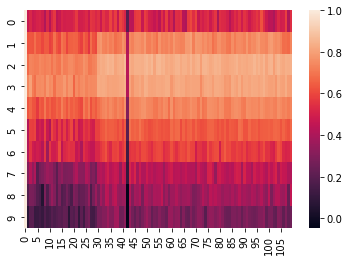

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
niids = [20, 40, 60, 80]
malicious_types = [{'flip': 5}, {'wrong_dataset': True}, {'lr':0.5}, {'lr':0.00001}]
experiment(device, niids, malicious_types, phase3)